In [130]:
import cv2
import imageio
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
from numpy import argmax
import os
from pickle import dump, load
from PIL import Image, ImageFilter
from scipy.ndimage import gaussian_filter, uniform_filter
import string
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [131]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

ROOT_DIR = "drive/MyDrive/Colab Notebooks"

DATASET_PATH = os.path.join(ROOT_DIR, "Dataset")

CAPTION_GENERATOR_PATH = os.path.join(ROOT_DIR, "CaptionGenerator")
CAPTION_GENERATOR_DATASET_PATH = os.path.join(CAPTION_GENERATOR_PATH, "Dataset")
CAPTION_GENERATOR_IMAGE_DATASET_PATH = os.path.join(CAPTION_GENERATOR_DATASET_PATH, "Flicker8k_Dataset")
CAPTION_GENERATOR_TEXT_DATASET_PATH = os.path.join(CAPTION_GENERATOR_DATASET_PATH, "Text")
CAPTION_GENERATOR_TRAIN_MODEL_FIT_PATH = os.path.join(CAPTION_GENERATOR_DATASET_PATH, "fit")
CAPTION_GENERATOR_IMAGES_PATH = os.path.join(CAPTION_GENERATOR_DATASET_PATH, "img")
print(CAPTION_GENERATOR_TEXT_DATASET_PATH)

CAPTION_GENERATOR_DESCRIPTIONS_FILENAME = os.path.join(CAPTION_GENERATOR_DATASET_PATH, "descriptions.txt")
CAPTION_GENERATOR_FEATURES_FILENAME = os.path.join(CAPTION_GENERATOR_DATASET_PATH, "features.pkl")
CAPTION_GENERATOR_TOKENIZER_FILENAME = os.path.join(CAPTION_GENERATOR_DATASET_PATH, "tokenizer.pkl")

CAPTION_GENERATOR_TOKEN_FILENAME = os.path.join(CAPTION_GENERATOR_TEXT_DATASET_PATH, "Flickr8k.token.txt")
CAPTION_GENERATOR_TRAIN_IMAGES_FILENAME = os.path.join(CAPTION_GENERATOR_TEXT_DATASET_PATH, "Flickr_8k.trainImages.txt")
CAPTION_GENERATOR_TEST_IMAGES_FILENAME = os.path.join(CAPTION_GENERATOR_TEXT_DATASET_PATH, "Flickr_8k.devImages.txt")

CAPTION_GENERATOR_TRAINING_EPOCHS = 20

drive/MyDrive/Colab Notebooks/CaptionGenerator/Dataset/Text


In [182]:
class ImageLoader:
  def convolve(self, image_data, filter, parameter=3):
    image_data = image_data[0]
    if filter == "" or filter == "none":
      pass
    elif filter == "gaussian":
      image_data = self.convolveGaussianFilter(image_data, parameter)
    elif filter == "uniform":
      image_data = self.convolveUniformFilter(image_data, parameter)
    else:
      print("Error: Unknown filter '" + filter + "'")
    image_data = np.expand_dims(image_data, axis=0)
    return image_data

  def convolveGaussianFilter(self, image_data, sigma=3):
    return np.array(Image.fromarray(image_data)
    .filter(ImageFilter.GaussianBlur(sigma)))

  def convolveUniformFilter(self, image_data, size=3):
    return np.array(Image.fromarray(image_data)
    .filter(ImageFilter.UnsharpMask(size)))
    #return gaussian_filter(image_data, size)

  def getImageData(self, image):
    return np.array(image)

  def readAndShowImage(self, image_path):
    image_data = self.readImage(image_path)
    self.showImage(image_data)

  def readImage(self, image_path, target_width, target_height):
    if os.path.isfile(image_path):
      #image_data = np.array(Image.open(image_path))
      image_data = cv2.imread(image_path)[:,:,::-1]
      image_data = self.resize(image_data, target_width, target_height)
      image_data = np.expand_dims(image_data, axis=0)
      return image_data
    else:
      print("ERROR: Invalid image path")

  def resize(self, image_data, target_width, target_height):
    image_data = cv2.resize(image_data, (target_width, target_height))
    return image_data

  def showImage(self, image_data):
    if len(image_data.shape) == 4:
      image_data = image_data[0]
    plt.imshow(image_data)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [165]:
class CaptionGenerator:
    
    IMAGE_WIDTH = 0
    IMAGE_HEIGHT = 0
    
    IMAGE_CLASSIFIER = None
    
    def __init__(self, image_width, image_height):
        self.IMAGE_WIDTH = image_width
        self.IMAGE_HEIGHT = image_height
        
        #self.IMAGE_CLASSIFIER = ImageClassifier(image_width, image_height)
        #self.IMAGE_CLASSIFIER.loadModel()
        
    def calculateDescriptionMaxLength(self, descriptions):
        lines = self.convertToLines(descriptions)
        return max(len(d.split()) for d in lines)
        
    def cleanDescriptions(self, descriptions):
        table = str.maketrans('', '', string.punctuation)
        for key, description_list in descriptions.items():
            for i in range(len(description_list)):
                description = description_list[i]
                description = description.split()
                description = [word.lower() for word in description]
                description = [w.translate(table) for w in description]
                description = [word for word in description if len(word)>1]
                description = [word for word in description if word.isalpha()]
                description_list[i] = ' '.join(description)
        
    def convertPath(self, path):
        validPath = ""
        for char in path:
            if char == '\\':
                validPath += "/"
            else:
                validPath += char
        return validPath
    
    def convertToLines(self, descriptions):
        all_descriptions = list()
        for key in descriptions.keys():
            [all_descriptions.append(d) for d in descriptions[key]]
        return all_descriptions
    
    def convertToVocabulary(self, descriptions):
        all_descriptions = set()
        for key in descriptions.keys():
            [all_descriptions.update(d.split()) for d in descriptions[key]]
        return all_descriptions
    
    def createSequences(self, tokenizer, max_length, description_list, photo, vocab_size):
        X1, X2, y = list(), list(), list()
        for description in description_list:
          sequence = tokenizer.texts_to_sequences([description])[0]
          for i in range(1, len(sequence)):
            in_seq, out_seq = sequence[:i], sequence[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
        return np.array(X1), np.array(X2), np.array(y)
    
    def createTokenizer(self, descriptions, verbose=True):
        lines = self.convertToLines(descriptions)
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(lines)
        vocab_size = len(tokenizer.word_index) + 1

        if verbose:
          print("Vocabulary size: %d" % vocab_size)

        return tokenizer, vocab_size
    
    def dataGenerator(self, descriptions, photos, tokenizer, max_length, vocab_size):
        while 1:
          for key, desc_list in descriptions.items():
            photo = photos[key][0]
            in_img, in_seq, out_word = self.createSequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [in_img, in_seq], out_word
    
    def defineModel(self, vocab_size, max_length, verbose=False):
        # Feature extractor model
        inputs1 = Input(shape=(4096,))
        fe1 = Dropout(0.5)(inputs1)
        fe2 = Dense(256, activation="relu")(fe1)
        
        # Sequence model
        inputs2 = Input(shape=(max_length,))
        se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
        se2 = Dropout(0.5)(se1)
        se3 = LSTM(256)(se2)
        
        # Decoder model
        decoder1 = add([fe2, se3])
        decoder2 = Dense(256, activation="relu")(decoder1)
        outputs = Dense(vocab_size, activation="softmax")(decoder2)
        
        model = Model(inputs=[inputs1, inputs2], outputs=outputs)
        model.compile(loss="categorical_crossentropy", optimizer="adam")
        
        if verbose:
            print(model.summary())
            
        plot_model(model, to_file="model.png", show_shapes=True)
        
        return model
    
    def evaluateModel(self, model_filename, verbose=True):
        train_descriptions, train_features = self.loadTrainingDataset(verbose)
        tokenizer, vocab_size = self.createTokenizer(train_descriptions, verbose)
        max_length = self.getMaxLength(train_descriptions)

        test_descriptions, test_features = self.loadTestSet()
        model = load_model(model_filename)
        
        actual, predicted = list(), list()
        for key, description_list in test_descriptions.items():
            yhat = self.generateDescription(model, tokenizer, test_features[key], max_length)
            references = [d.split() for d in description_list]
            actual.append(references)
            predicted.append(yhat.split())
            
        print("Evaluated model: %s" % model_filename)
        print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
        print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
        print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
        print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

    def evaluateModels(self, directory=CAPTION_GENERATOR_TRAIN_MODEL_FIT_PATH):
        for model in os.listdir(directory):
          if(model.endswith(".h5")):
            self.evaluateModel(os.path.join(directory, model))
        
    def extractFeatures(self, filename, output_file=CAPTION_GENERATOR_FEATURES_FILENAME, verbose=1):
        model = VGG16()
        model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
        if(verbose >= 2):
            print(model.summary())

        if isinstance(filename, np.ndarray):
            image = preprocess_input(filename)
            feature = model.predict(image, verbose=0)
            return feature

        else:            
            if os.path.isdir(filename):
                features = dict()
                for name in os.listdir(filename):
                    filename = filename + '/' + name
                    image = load_img(filename, target_size=(self.IMAGE_WIDTH, self.IMAGE_HEIGHT))
                    image = img_to_array(image)
                    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
                    image = preprocess_input(image)
                    feature = model.predict(image, verbose=0)
                    image_id = name.split('.')[0]
                    features[image_id] = feature
                    if(verbose >= 3):
                        print('>%s' % name) 
            
                if verbose >= 1:
                    print("Extracted Features: %d" % len(features))
                
                dump(features, open(DATASET_PATH + output_file, 'wb'))
            
                return features
                
            elif os.path.isfile(filename):
                image = load_img(filename, target_size=(self.IMAGE_WIDTH, self.IMAGE_HEIGHT))
                image = img_to_array(image)
                image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
                image = preprocess_input(image)
                feature = model.predict(image, verbose=0)
                return feature
            
    
    def fitCaptioningModel(self, train_descriptions, train_features, tokenizer, vocab_size, max_length, epochs=20):
        model = self.defineCaptioningModel(vocab_size, max_length, summarize=True)
        steps = len(train_descriptions)
        for i in range(epochs):
            generator = self.dataGenerator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
            model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=2)
            model.save(os.path.join(CAPTION_GENERATOR_TRAIN_MODEL_FIT_PATH, "model_%d.h5" % i))

    def fitTrainingModelWithProgressiveLoading(self, 
                                               verbose=True, 
                                               epochs=CAPTION_GENERATOR_TRAINING_EPOCHS,
                                               initial_epoch=0):
        train_descriptions, train_features = self.loadTrainingDataset(verbose)
        tokenizer, vocab_size = self.createTokenizer(train_descriptions, verbose)
        max_length = self.getMaxLength(train_descriptions)

        if initial_epoch == 0:
          model = self.defineModel(vocab_size, max_length, verbose)
        else:
          model_path = os.path.join(CAPTION_GENERATOR_TRAIN_MODEL_FIT_PATH, "model_%d.h5" % int(initial_epoch - 1))
          model = load_model(model_path)
          if verbose:
            print("Load model %s" % model_path)

        for epoch in range(initial_epoch, epochs):
          print("Epoch %d" % epoch)
          generator = self.dataGenerator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
          model.fit(generator, epochs=1, steps_per_epoch=len(train_descriptions))
          model.save(os.path.join(CAPTION_GENERATOR_TRAIN_MODEL_FIT_PATH, "model_%d.h5" % epoch))
    
    def generateAndSaveTokenizer(self, 
                                 filename=CAPTION_GENERATOR_TOKENIZER_FILENAME,
                                 verbose=True, 
                                 descriptions_filename=CAPTION_GENERATOR_DESCRIPTIONS_FILENAME):
        train = self.loadSet(CAPTION_GENERATOR_TRAIN_IMAGES_FILENAME)
        if verbose:
            print("Dataset: %d" % len(train))
        
        train_descriptions = self.loadCleanDescriptions(train, filename=descriptions_filename)
        if verbose:
            print("Descriptions: train=%d" % len(train_descriptions))
        
        tokenizer = self.createTokenizer(train_descriptions)
        dump(tokenizer, open(filename, "wb"))
        
        if verbose:
            print("Tokenizer saved to file '" + filename + "'")
    
    def generateCaption(self, 
                        image_path, 
                        show_image=True, 
                        captioning_model=os.path.join(CAPTION_GENERATOR_TRAIN_MODEL_FIT_PATH, "model_0.h5")):
    #    image_path = self.convertPath(image_path)
    #    image = self.readImageFile(image_path)
    #    self.IMAGE_CLASSIFIER.predict(image)
        #print(os.path.join(CAPTION_GENERATOR_IMAGES_PATH, image_path))
        #if not os.path.isfile(os.path.join(CAPTION_GENERATOR_IMAGES_PATH, image_path)):
        #    print("Invalid image path")
        #    return
    
        tokenizer = load(open(CAPTION_GENERATOR_TOKENIZER_FILENAME, "rb"))
        max_length = 34
        model = load_model(captioning_model)
        
        #if show_image:
        #    image = plt.imread(image_path)
        #    plt.xticks([])
        #    plt.yticks([])
        #    plt.imshow(image)
        #    plt.show()
            
        
        photo = self.extractFeatures(image_path)
        caption = self.generateDescription(model, tokenizer, photo, max_length)
        caption = caption[9: len(caption)-7]
            
        return caption
        
    def generateDescription(self, model, tokenizer, photo, max_length):
        in_text = "startseq"
        for i in range(max_length):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)
            yhat = model.predict([photo, sequence], verbose=0)
            yhat = argmax(yhat)
            word = self.wordFromId(yhat, tokenizer)
            if word is None:
                break
            
            in_text += ' ' + word
            
            if word == 'endseq':
                break
        return in_text

    def getMaxLength(self, descriptions):
        lines = self.convertToLines(descriptions)
        return max(len(description.split()) for description in lines)
        
    def getTextFileContent(self, filename):
        file = open(filename, 'r')
        text = file.read()
        file.close()
        return text
        
    def loadCleanDescriptions(self, 
                              dataset, 
                              descriptions_filename=CAPTION_GENERATOR_DESCRIPTIONS_FILENAME):
        doc = self.getTextFileContent(descriptions_filename)
        descriptions = dict()
        for line in doc.split('\n'):
            tokens = line.split()
            image_id, image_description = tokens[0], tokens[1:]
            if image_id in dataset:
                if image_id not in descriptions:
                    descriptions[image_id] = list()
                description = 'startseq ' + ' '.join(image_description) + ' endseq'
                descriptions[image_id].append(description)
        return descriptions

    def loadDescriptions(self, filename):
        text = self.getTextFileContent(filename)

        mapping = dict()
        for line in text.split('\n'):
            tokens = line.split()
            if len(line) < 2:
                continue
            image_id, image_description = tokens[0], tokens[1:]
            image_id = image_id.split('.')[0]
            image_description = ' '.join(image_description)
            if image_id not in mapping:
                mapping[image_id] = list()
            mapping[image_id].append(image_description)
        return mapping
    
    def loadPhotoFeatures(self, dataset, features_filename=CAPTION_GENERATOR_FEATURES_FILENAME):
        all_features = load(open(features_filename, 'rb'))
        features = {k: all_features[k] for k in dataset}
        return features
    
    def loadSet(self, filename):
        doc = self.getTextFileContent(filename)
        dataset = list()
        for line in doc.split('\n'):
            if len(line) < 1:
                continue
            identifier = line.split('.')[0]
            dataset.append(identifier)
        return set(dataset)

    def loadTestSet(self, verbose=True):
        test = self.loadSet(CAPTION_GENERATOR_TEST_IMAGES_FILENAME)
        test_descriptions = self.loadCleanDescriptions(test)
        test_features = self.loadPhotoFeatures(test)

        if verbose:
          print("Dataset: %d" % len(test))
          print("Descriptions: test=%d" % len(test_descriptions))
          print("Photos: test=%d" % len(test_features))

        return test_descriptions, test_features

    def loadTrainingDataset(self, verbose=True):
        train = self.loadSet(CAPTION_GENERATOR_TRAIN_IMAGES_FILENAME)
        train_descriptions = self.loadCleanDescriptions(train)
        train_features = self.loadPhotoFeatures(train)
        if verbose:
          print("Dataset: %d" % len(train))
          print("Descriptions: train=%d" % len(train_descriptions))
          print("Photos: train=%d" % len(train_features))

        return train_descriptions, train_features
    
    def prepareImageCaptioningTrainDataset(self):
        descriptions = self.loadDescriptions(CAPTION_GENERATOR_TOKEN_FILENAME)
        self.cleanDescriptions(descriptions)
        vocabulary = self.convertToVocabulary(descriptions)
        self.saveDescriptions(descriptions)
        
    def prepareTestDataset(self):
        filename = CAPTION_GENERATOR_TEST_IMAGES_FILENAME
        test = self.loadSet(filename)
        print("Dataset: %d" % len(test))
        
        test_descriptions = self.loadCleanDescriptions(test)
        print("Descriptions: test=%d" % len(test_descriptions))
        
        test_features = self.loadPhotoFeatures(CAPTION_GENERATOR_FEATURES_FILENAME, test)
        print("Photos: test=%d" % len(test_features))
        
        return test_descriptions, test_features
        
    def prepareTrainingDataset(self):
        filename = CAPTION_GENERATOR_TRAIN_IMAGES_FILENAME
        train = self.loadSet(filename)
        print("Dataset: %d" % len(train))
        
        train_descriptions = self.loadCleanDescriptions(train)
        print("Descriptions: train=%d" %len(train_descriptions))
        
        train_features = self.loadPhotoFeatures(train, CAPTION_GENERATOR_FEATURES_FILENAME)
        print("Photos: train=%d" % len(train_features))   
        
        tokenizer, vocab_size = self.createTokenizer(train_descriptions)
        print("Vocabulary size: %d" % vocab_size)
        
        max_length = self.calculateDescriptionMaxLength(train_descriptions)
        print("Description length: %d" % max_length)
        
        return train_descriptions, train_features, tokenizer, vocab_size, max_length
    
    def readImageFile(self, image_path):
        if not os.path.isfile(image_path):
            print("Unknow path")
            return None
        else:
            image = cv2.imread(image_path)
            image = cv2.resize(image, (self.IMAGE_WIDTH, self.IMAGE_HEIGHT))
            image = np.expand_dims(image, axis=0)
            return image
        
    def saveDescriptions(self, 
                         descriptions=None, 
                         filename=CAPTION_GENERATOR_DESCRIPTIONS_FILENAME,
                         verbose=True):
        print(filename)
        if descriptions == None:
          descriptions = self.loadDescriptions(CAPTION_GENERATOR_TOKEN_FILENAME)
          self.cleanDescriptions(descriptions)
          vocabulary = self.convertToVocabulary(descriptions)
          
          if verbose:
            print("Loaded: %d" % len(descriptions))
            print("Vocabulary size: %d" % len(vocabulary))

        lines = list()
        for key, description_list in descriptions.items():
            for description in description_list:
                lines.append(key + ' ' + description)
        data = '\n'.join(lines)
        file = open(filename, 'w')
        file.write(data)
        file.close()
        
    def wordFromId(self, integer, tokenizer):
        for word, index in tokenizer.word_index.items():
            if index == integer:
                return word
        return None

In [134]:
class ImageClassifier:

    IMAGE_CLASSIFIER_PATH = os.path.join(ROOT_DIR, "ImageClassifier")
    FIT_DIR_PATH = os.path.join(IMAGE_CLASSIFIER_PATH, "fit")
    
    DATASETS_PATH = "D:/Cours/Cesi/A5/UE/Option - Data Science/Projet/Livrable 2/Datasets/extracted"
    CLASS_NAMES = ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']
    
    VALIDATION_SPLIT = 0.3
    
    IMAGE_WIDTH = 0
    IMAGE_HEIGHT = 0
    
    MODEL = None
    EPOCHS = 0
    HISTORY = None
    
    def __init__(self, image_width, image_height, model="model_0.780.h5"):
        self.IMAGE_WIDTH = image_width
        self.IMAGE_HEIGHT = image_height

        self.MODEL = load_model(os.path.join(self.FIT_DIR_PATH, model))
        
    def buildModel(self, dropout_rate=0, kernel_regularizer_l1=0.00, kernel_regularizer_l2=0.0):
        model = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(self.IMAGE_HEIGHT, self.IMAGE_WIDTH, 3)),
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(self.IMAGE_HEIGHT, self.IMAGE_WIDTH, 3)),
            tf.keras.layers.experimental.preprocessing.RandomRotation(10),
            tf.keras.layers.experimental.preprocessing.RandomZoom((0.2, 0.5)),
            tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu", 
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=kernel_regularizer_l1, l2=kernel_regularizer_l2)),
            tf.keras.layers.MaxPooling2D((2,2), padding='same'),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", 
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=kernel_regularizer_l1, l2=kernel_regularizer_l2)),
            tf.keras.layers.MaxPooling2D((2,2), padding='same'),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", 
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=kernel_regularizer_l1, l2=kernel_regularizer_l2)),
            tf.keras.layers.MaxPooling2D((2,2), padding='same'),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=kernel_regularizer_l1, l2=kernel_regularizer_l2)),
            tf.keras.layers.Dense(len(self.CLASS_NAMES))
        ])
        
        model.compile(optimizer="adam",
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           metrics=["accuracy"])
        
        plot_model(model, to_file="model.png", show_shapes=True)

        return model
        
    def fit(self, 
            epochs, 
            save_path=None, 
            model_filename="ImageClassifierModel.h5",
            show_training_results=False, 
            dropout_rate=0, 
            kernel_regularizer_l1=0.01, 
            kernel_regularizer_l2=0.01):
        train_dataset, test_dataset = self.generateDatasets()
        self.MODEL = self.buildModel(dropout_rate, kernel_regularizer_l1, kernel_regularizer_l2)
        self.EPOCHS = epochs
        
        earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
        checkpointsCallback = tf.keras.callbacks.ModelCheckpoint(os.path.join(save_path, "model_{val_accuracy:.3f}.h5"),
                                           save_best_only=True,
                                           save_weights_only=False,
                                           monitor='val_accuracy')
        self.HISTORY = self.MODEL.fit(train_dataset, 
                                      validation_data=test_dataset, 
                                      epochs=epochs, 
                                      callbacks=[earlyStoppingCallback, checkpointsCallback])
        
        if save_path != None:
            self.MODEL.save(os.path.join(save_path, model_filename))
            
        if show_training_results:
            self.showTrainingResults()
    
    def generateDatasets(self):
        datasets = []
        
        for subset_label in ['training', 'validation']:
            datasets.append(tf.keras.preprocessing.image_dataset_from_directory(
            self.DATASETS_PATH,
            labels="inferred",
            label_mode="int",
            validation_split=self.VALIDATION_SPLIT,
            subset=subset_label,
            seed=42,
            color_mode="rgb",
            image_size=(self.IMAGE_WIDTH, self.IMAGE_HEIGHT)))
        return datasets[0], datasets[1]

    def isPhoto(self, image_data):
      if self.MODEL == None:
        print("ERROR: Model is not defined")
        return
      
      prediction = self.MODEL.predict(image_data)
      if np.argmax(prediction) == self.CLASS_NAMES.index('Photo'):
        return True
      else:
        return False
      print(np.argmax(prediction))
    
    def loadModel(self, model_path="ImageClassifier/ImageClassifier.h5", add_softmax_layer=True):
        model = tf.keras.models.load_model(model_path)
        if add_softmax_layer:
            model.add(tf.keras.layers.Softmax())
        self.MODEL = model
        
    def modelSummary(self):
        self.MODEL.summary()
        
    def predict(self,
                image_data,
                model_path="model_0.780.h5",
                verbose=False):
      if not model_path.endswith(".h5"):
        print("ERROR: Invalid classifier model")
        return
      
      print(image_data.shape)
      model = load_model(os.path.join(self.FIT_DIR_PATH, model_path))
      #prediction = model.predict(tf.convert_to_tensor(image))
      prediction = model.predict(image_data)
      predicted_class_id = np.argmax(prediction)
      predicted_class = self.CLASS_NAMES[predicted_class_id]
      print(predicted_class)
      return predicted_class, predicted_class_id
        
    def showTrainingResults():
        epochs_range = range(self.EPOCHS)
    
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.HISTORY.history['accuracy'], label="Training accuracy")
        plt.plot(epochs_range, self.HISTORY.history['val_accuracy'], label="Validation accuracy")
        plt.legend()
        plt.title("Training and validation accuracy")

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.HISTORY.history['loss'], label="Training loss")
        plt.plot(epochs_range, self.HISTORY.history['val_loss'], label="Validation loss")
        plt.legend()
        plt.title("Training and validation loss")

        plt.show()

In [12]:
captionGenerator = CaptionGenerator(IMAGE_WIDTH, IMAGE_HEIGHT)
train_descriptions, train_features = captionGenerator.loadTrainingDataset()
tokenizer, vocab_size = captionGenerator.createTokenizer(train_descriptions)
max_length = captionGenerator.getMaxLength(train_descriptions)

#captionGenerator.defineModel(vocab_size, max_length)
#captionGenerator.saveDescriptions()

#train_descriptions, train_features = captionGenerator.loadTrainingDataset()

#tokenizer, vocab_size = captionGenerator.createTokenizer(train_descriptions)

#train_dataset, train_features, tokenizer, vocab_size, max_length = captionGenerator.prepareTrainingDataset()

#captionGenerator.fitTrainingModelWithProgressiveLoading(epochs=20)

#captionGenerator.evaluateModels()

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary size: 7579


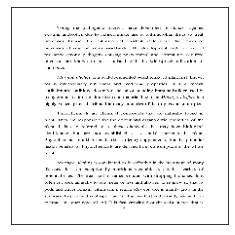

The given file is not a photo


In [388]:
image_filename = "text1.png"
filter = "gaussian"
size = 1
revert = False

def main(revert=False):
    # Chargement de l'image
    imageLoader = ImageLoader()
    image_path = os.path.join(DATASET_PATH, image_filename)
    image_data = imageLoader.readImage(image_path, IMAGE_WIDTH, IMAGE_HEIGHT)

    # Affichage initial
    imageLoader.showImage(image_data) 

    if revert:  

      # Convolution
      image_data = imageLoader.convolve(image_data, filter, size)
      if filter != "":
        imageLoader.showImage(image_data)  

      # Classification
      imageClassifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
      if not imageClassifier.isPhoto(image_data):
        print("The given file is not a photo")
        return

    else: 

      # Classification
      imageClassifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
      if not imageClassifier.isPhoto(image_data):
        print("The given file is not a photo")
        return

      # Convolution
      image_data = imageLoader.convolve(image_data, filter, size)
      if filter != "":
        imageLoader.showImage(image_data)

    # Génération de la légende
    captionGenerator = CaptionGenerator(IMAGE_WIDTH, IMAGE_HEIGHT)
    caption = captionGenerator.generateCaption(image_data)
    print(caption)

main(revert)


#image_data = image_data.reshape(image_data.shape[0], image_data.shape[1], image_data.shape[2], 1)
#image_path = os.path.join(CAPTION_GENERATOR_IMAGE_DATASET_PATH, "47871819_db55ac4699.jpg")
#image_path = os.path.join(DATASET_PATH, "photo2.jpg")
#print(os.path.isfile(image_path))
#image_data = imageLoader.readImage(image_path)
#imageLoader.resize(image_data, IMAGE_WIDTH, IMAGE_HEIGHT)
#image_data = imageLoader.convolveGaussianFilter(image_data, 3)
#imageLoader.showImage(image_data)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
